In [ ]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/NBS_project/'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.getcwd()

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

from src.config import Config
from src.main import create_MDs,create_ESP
import src.baseline as baseline
import src.NBS as NBS
import src.model as model
import numpy as np
import matplotlib.pyplot as plt
import copy

项目路径设置为: c:\Users\a1831\Desktop\NBS_Project


In [ ]:
# Experiment 1: Performance of Proposed Algorithm
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "test.json")
config = Config(CONFIG_PATH)
lambda0 = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
sw_uni, sw_pro, sw_non, sw_con, sw_swm, sw_admm = [],[],[],[],[],[]
Dm_uni, Dm_pro, Dm_non, Dm_con, Dm_swm, Dm_admm = [],[],[],[],[],[]
for l0 in lambda0:
  config.params["lambda0"] = l0
  print(f"=====Lambda 0: {l0}=====")
  
  seed = 41
  MDs = create_MDs(config, seed=seed)
  esp = create_ESP(config, seed=seed)
  # for md in MDs[:n]:
  #   print(md.param)
  # print(esp.param)

  T = 15
  N = len(MDs)
  lam_uni, p_uni, r_uni, Dmax_uni = np.zeros(N),np.zeros(N),np.zeros(N),0
  for _ in range(T):
      l,p,r,d = baseline.uniform_baseline_smarter(esp, MDs)
      lam_uni += l
      p_uni += p
      r_uni += r
      Dmax_uni += d
  lam_uni, p_uni, r_uni, Dmax_uni = lam_uni/T, p_uni/T, r_uni/T, Dmax_uni/T
  print(f"Uniform Baseline: SW={model.social_welfare(esp, MDs, lam_uni, p_uni)}, Dmax={Dmax_uni}")

  lam_pro, p_pro, r_pro, Dmax_pro = np.zeros(N),np.zeros(N),np.zeros(N),0
  for _ in range(T):
      l,p,r,d = baseline.proportional_baseline_smarter(esp,MDs)
      lam_pro += l
      p_pro += p
      r_pro += r
      Dmax_pro += d
  lam_pro, p_pro, r_pro, Dmax_pro = lam_pro/T, p_pro/T, r_pro/T, Dmax_pro/T
  print(f"Proportional Baseline: SW={model.social_welfare(esp, MDs, lam_pro, p_pro)}, Dmax={Dmax_pro}")

  lam_non, p_non, r_non, Dmax_non = baseline.non_cooperative_baseline(esp,MDs)
  print(f"Non-Cooperative Baseline: SW={model.social_welfare(esp, MDs, lam_non, p_non)}, Dmax={Dmax_non}")
  lam_con, p_con, r_con, Dmax_con = baseline.contract_type_based_baseline(esp,MDs,K=5)
  print(f"Contract Baseline: SW={model.social_welfare(esp, MDs, lam_con, p_con)}, Dmax={Dmax_con}")
  lam_swm, p_swm, Dmax_swm = baseline.social_welfare_maximization(esp, MDs)
  print(f"SWM Baseline: SW={model.social_welfare(esp, MDs, lam_swm, p_swm)}, Dmax={Dmax_swm}")
  lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
  r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
  print(f"ADMM Baseline: SW={model.social_welfare(esp, MDs, lamb_admm, p_admm)}, Dmax={Dmax_admm}")

  sw_uni.append(model.social_welfare(esp, MDs, lam_uni, p_uni))
  sw_pro.append(model.social_welfare(esp, MDs, lam_pro, p_pro))
  sw_non.append(model.social_welfare(esp, MDs, lam_non, p_non))
  sw_con.append(model.social_welfare(esp, MDs, lam_con, p_con))
  sw_swm.append(model.social_welfare(esp, MDs, lam_swm, p_swm))
  sw_admm.append(model.social_welfare(esp, MDs, lamb_admm, p_admm))
  Dm_uni.append(Dmax_uni)
  Dm_pro.append(Dmax_pro)
  Dm_non.append(Dmax_non)
  Dm_con.append(Dmax_con)
  # Dm_rev.append(0)  # Placeholder for reverse auction
  # Dm_gre.append(0)  # Placeholder for greedy heuristic
  Dm_swm.append(Dmax_swm)
  Dm_admm.append(Dmax_admm)
  print("===================")
sw = [sw_uni, sw_pro, sw_non, sw_con, sw_admm]
Dm = [Dm_uni, Dm_pro, Dm_non, Dm_con, Dm_admm]


=====Lambda 0: 50=====
Uniform Baseline: SW=-14.372568364611785, Dmax=0.9181549454216558
Proportional Baseline: SW=-3.14991553605278, Dmax=0.8959238549262039
Non-Cooperative Baseline: SW=17.83749096414354, Dmax=0.6462555940513434


c:\Users\a1831\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Contract Baseline: SW=24.965557483707784, Dmax=0.47514272187048595
SWM Baseline: SW=27.975485942697873, Dmax=0.3197814841847888


c:\Users\a1831\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ADMM Baseline: SW=27.9435350382647, Dmax=0.31986559355658595
=====Lambda 0: 60=====
Uniform Baseline: SW=-7.502857564468301, Dmax=0.9301736657385082
Proportional Baseline: SW=8.086741605214527, Dmax=0.8756744813743934
Non-Cooperative Baseline: SW=25.032475073957954, Dmax=0.6715624208571006
Contract Baseline: SW=32.370366230766365, Dmax=0.5188391600988697
SWM Baseline: SW=36.947736267985675, Dmax=0.32543824199902843
ADMM Baseline: SW=36.91806525803588, Dmax=0.3255265859268246
=====Lambda 0: 70=====
Uniform Baseline: SW=6.568162911623494, Dmax=0.9335559227438898
Proportional Baseline: SW=18.08590536556855, Dmax=0.8838455301383984
Non-Cooperative Baseline: SW=32.11595790213534, Dmax=0.6940273226748066
Contract Baseline: SW=39.09859185939042, Dmax=0.567610515848798
SWM Baseline: SW=45.86292812965718, Dmax=0.3309200822548234
ADMM Baseline: SW=45.83572622052212, Dmax=0.3310072611133923
=====Lambda 0: 80=====
Uniform Baseline: SW=10.772385510039639, Dmax=0.9392318128031842
Proportional Baseli

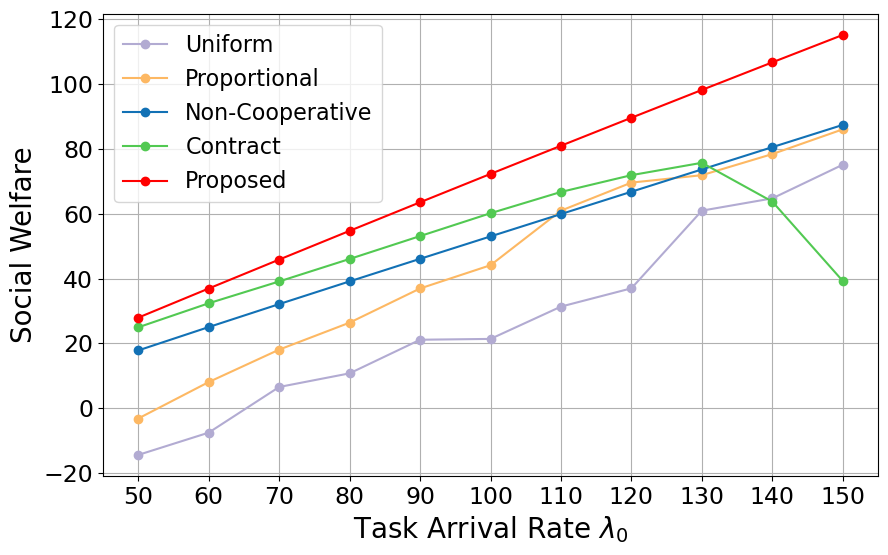

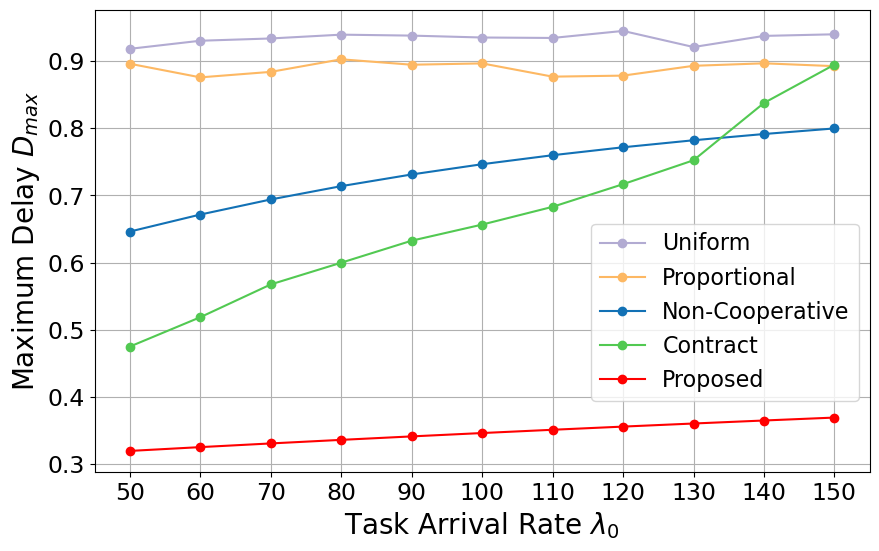

In [ ]:
baselines = ['Uniform', 'Proportional', 'Non-Cooperative', 'Contract', 'Proposed']
color_map = {
    'Proposed': 'red',
    'Contract': "#52c952",
    'Non-Cooperative': "#1271b5", 
    'Proportional': '#fdb863', 
    'Uniform': "#b2abd2"   
}
plt.rc('axes', labelsize=20)         # 坐标轴标签字体
plt.rc('xtick', labelsize=17)        # x 轴刻度
plt.rc('ytick', labelsize=17)        # y 轴刻度
plt.rc('legend', fontsize=16)        # 图例

plt.figure(figsize=(10, 6)) # 设置图的大小
for i, data in enumerate(sw):
    plt.plot(lambda0, data, marker='o', label=f'{baselines[i]}',color=color_map[baselines[i]])

# plt.title('Social Welfare vs. $\lambda_0$')
plt.xlabel('Task Arrival Rate $\lambda_0$')
plt.ylabel('Social Welfare')
plt.xticks(lambda0) # 确保 N 值在横轴上清晰显示
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6)) # 设置图的大小
for i, data in enumerate(Dm):
    plt.plot(lambda0, data, marker='o', label=f'{baselines[i]}',color=color_map[baselines[i]])

# plt.title('Delay vs. $\lambda_0$')
plt.xlabel('Task Arrival Rate $\lambda_0$')
plt.ylabel('Maximum Delay $D_{max}$ (seconds)')
plt.xticks(lambda0) # 确保 N 值在横轴上清晰显示
plt.grid(True)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.13))
plt.show()

In [5]:
# sw_opt, Dm_opt = [], []
# for l0 in lambda0:
#     print(f"=====Lambda 0: {l0}=====")
#     esp.lambda0 = l0
#     lam_opt, p_opt, r_opt, Dmax_opt = baseline.optimal_NBP_fast(esp, MDs)
#     print(lam_opt, p_opt, r_opt, Dmax_opt)
#     sw_opt.append(model.social_welfare(esp, MDs, lam_opt, p_opt))
#     Dm_opt.append(Dmax_opt)
#     print(f"Optimal Baseline: SW={sw_opt[-1]}, Dmax={Dmax_opt}")

# print(f"Opt SOcial Welfare: {sw_opt}")
print(f"SWM Social Welfare: {sw_swm}")
print(f"ADMM Social Welfare: {sw_admm}")
# print(f"Optimal Maximum Delay: {Dm_opt}")
print(f"SWM Maximum Delay: {Dm_swm}")
print(f"ADMM Maximum Delay: {Dm_admm}")

SWM Social Welfare: [27.975485942697873, 36.947736267985675, 45.86292812965718, 54.720934002381725, 63.52149174325826, 72.26427579291236, 80.9489204481733, 89.57504529631802, 98.14225449766707, 106.65014820104054, 115.09831834735019]
ADMM Social Welfare: [27.9435350382647, 36.91806525803588, 45.83572622052212, 54.6958798190588, 63.49825356481252, 72.24236473340342, 80.92869393677289, 89.55597722198152, 98.12426179752447, 106.63301284543074, 115.08159878657268]
SWM Maximum Delay: [0.3197814841847888, 0.32543824199902843, 0.3309200822548234, 0.33623391097167504, 0.34138795130001015, 0.3463901244110853, 0.3512498269473177, 0.35597559547660723, 0.3605679278618982, 0.36504167831121165, 0.36940003401373417]
ADMM Maximum Delay: [0.31986559355658595, 0.3255265859268246, 0.3310072611133923, 0.33631965715679657, 0.34147413310092467, 0.34647391994210325, 0.35133376359032636, 0.3560554032837196, 0.36065232856204466, 0.365125331028492, 0.36948391543536246]


In [20]:
# Experiment 2: Comparison of NBS and Non-Cooperative
CONFIG2_PATH = os.path.join(PROJECT_PATH, "configs", "test2.json")
config2 = Config(CONFIG2_PATH)
seed = 41
MDs = create_MDs(config2, seed=seed)
esp = create_ESP(config2, seed=seed)
for md in MDs:
    print(md.param)
print(esp.param)


lam_non, p_non, r_non, Dmax_non = baseline.non_cooperative_baseline(esp,MDs)
print(f"Non-Cooperative Baseline: SW={model.social_welfare(esp, MDs, lam_non, p_non)}, Dmax={Dmax_non}")

lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
print(f"ADMM Baseline: SW={model.social_welfare(esp, MDs, lamb_admm, p_admm)}, Dmax={Dmax_admm}")

utility_non = [md.utility(p_non[i], r_non[i]) for i,md in enumerate(MDs)]
utility_admm = [md.utility(p_admm[i], r_admm[i]) for i,md in enumerate(MDs)]
utility_non.append(esp.utility(Dmax_non, r_non))
utility_admm.append(esp.utility(Dmax_admm, r_admm))
print(f"Non-Cooperative Lambda: {lam_non}")
print(f"ADMM Lambda: {lamb_admm}")
print(f"Non-Cooperative p: {p_non}")
print(f"ADMM p: {p_admm}")
print(f"Non-Cooperative r: {r_non}")
print(f"ADMM r: {r_admm}")
print(f"Non-Cooperative Utility: {utility_non}")
print(f"ADMM Utility: {utility_admm}")

{'s': 0.1, 'l': 0.8, 'cn': 0.900369449497976, 'Fn': 1.184383282690447, 'kn': 0.6414529928884467, 'omega_n': 1, 'Rn': 4.13472934445215}
{'s': 0.1, 'l': 0.8, 'cn': 1.0415462755795253, 'Fn': 1.7637226511189565, 'kn': 0.6348125738082766, 'omega_n': 1, 'Rn': 10.248845012378245}
{'s': 0.1, 'l': 0.8, 'cn': 0.932903940019097, 'Fn': 2.1321345406869066, 'kn': 0.24902581391857953, 'omega_n': 1, 'Rn': 6.716553285779903}
{'s': 0.1, 'l': 0.8, 'cn': 0.8278081871246422, 'Fn': 3.8199302863134226, 'kn': 0.35174154718363215, 'omega_n': 1, 'Rn': 9.231363952354403}
{'s': 0.1, 'l': 0.8, 'cn': 1.0432905838092195, 'Fn': 3.913825949541608, 'kn': 0.43740643005316393, 'omega_n': 1, 'Rn': 7.948101841125762}
{'lambda0': 50, 'D0': 1, 'theta': 1, 'o': 10, 'omega_0': 2, 's': 0.1, 'l': 0.8}
Non-Cooperative Baseline: SW=9.861243724330638, Dmax=0.7167516998325615
ADMM Baseline: SW=28.422998158229095, Dmax=0.2565071356626366
Non-Cooperative Lambda: [ 6.63759815  6.81731827 11.7847358  14.88529452  9.87505325]
ADMM Lambda

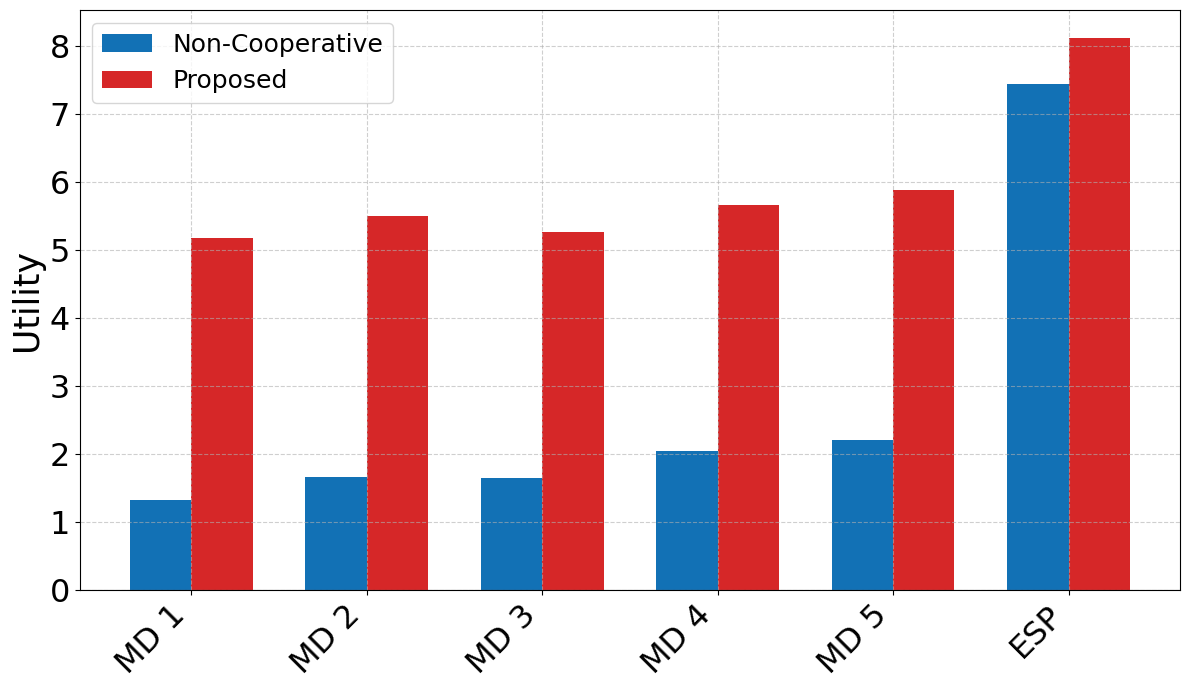

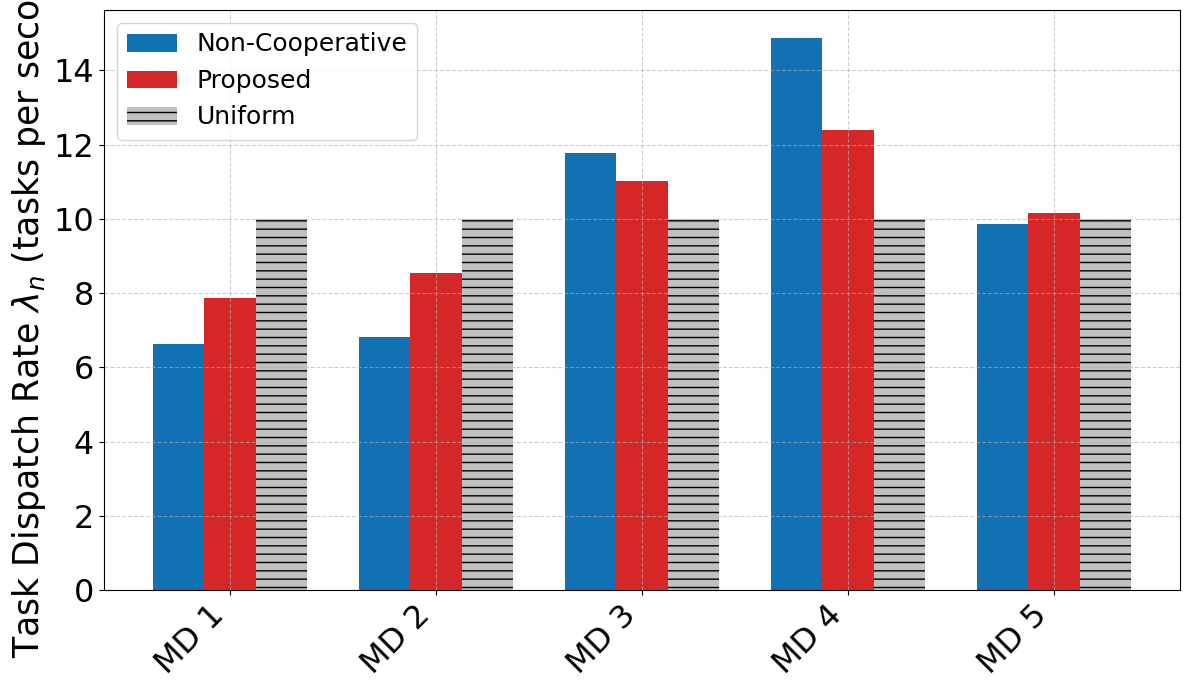

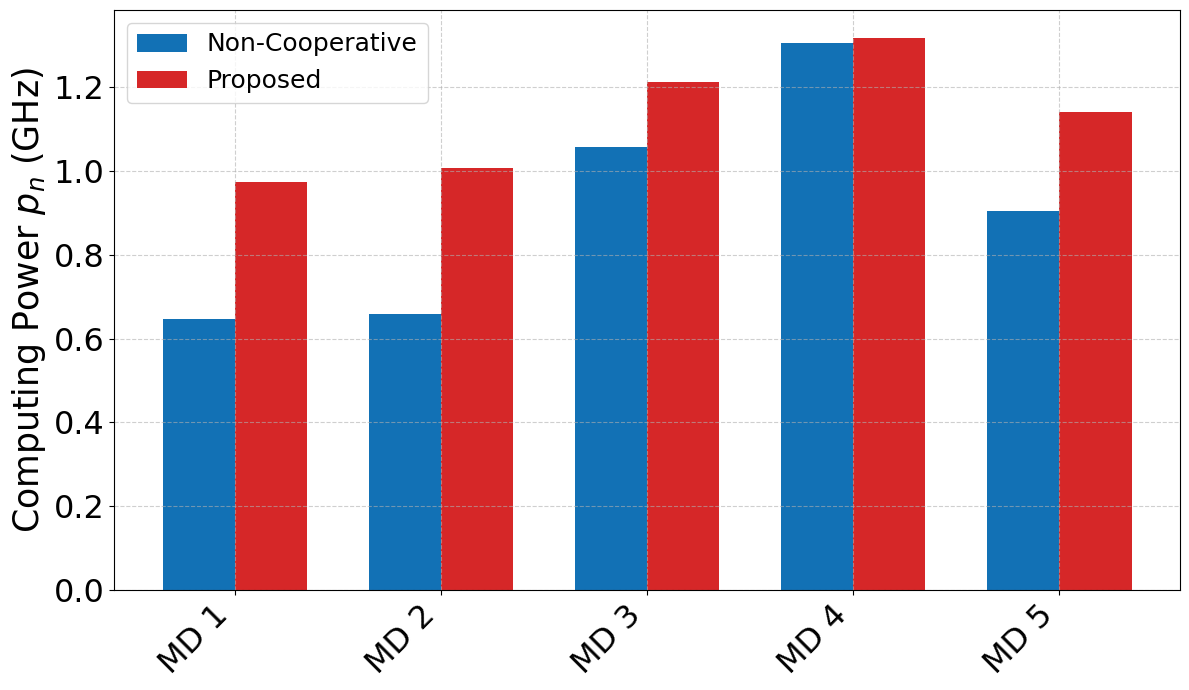

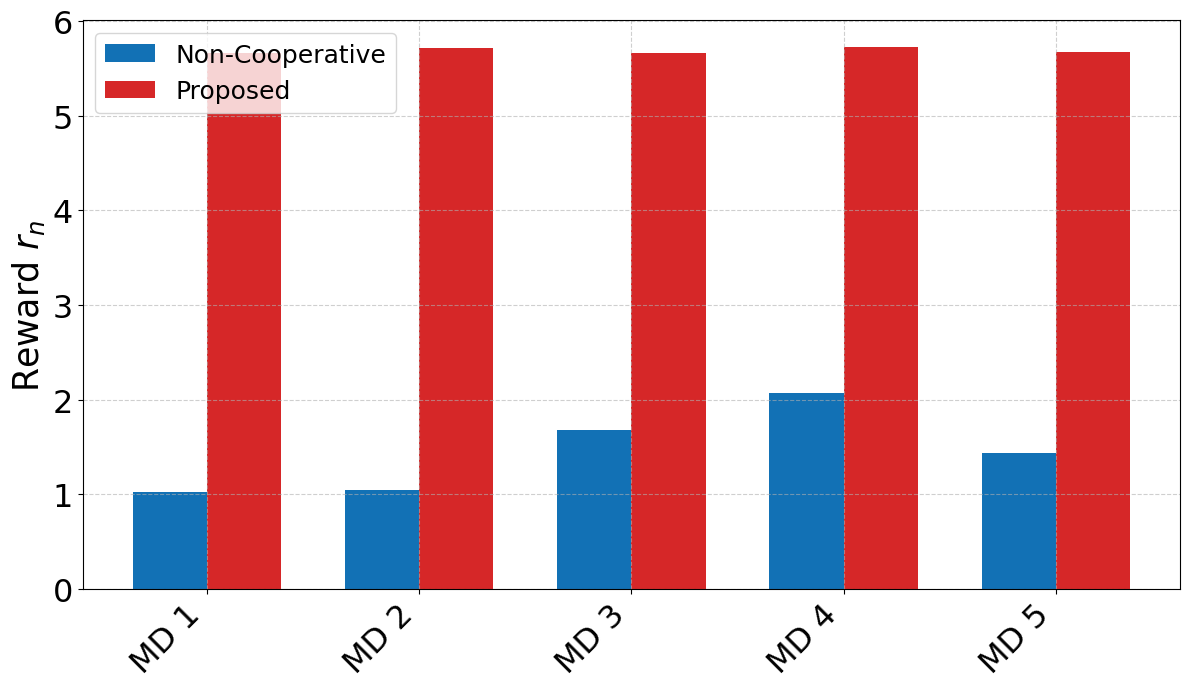

In [29]:
plt.rc('axes', labelsize=25)         # 坐标轴标签字体
plt.rc('xtick', labelsize=23)        # x 轴刻度
plt.rc('ytick', labelsize=23)        # y 轴刻度
plt.rc('legend', fontsize=18)        # 图例
# 创建X轴的标签，包括N个MD和1个ESP
N = len(MDs)
labels_utility = [f'MD {i+1}' for i in range(N)] + ['ESP']
labels = labels_utility[:N]
# X轴的位置
x_utility = np.arange(len(labels_utility))  
x = np.arange(len(labels))
# 每个柱子的宽度
width = 0.35  

# 定义颜色 (可以替换为您喜欢的颜色)
color_non_cooperative = '#1271b5'
color_admm = '#d62728' # 使用我们之前讨论过的砖红色

# --- 3. 绘制四个对比图 ---

# 图一：Utility 对比
fig1, ax1 = plt.subplots(figsize=(12, 7))
rects1 = ax1.bar(x_utility - width/2, utility_non, width, label='Non-Cooperative', color=color_non_cooperative)
rects2 = ax1.bar(x_utility + width/2, utility_admm, width, label='Proposed', color=color_admm)

# 添加标题和标签
ax1.set_ylabel('Utility')
# ax1.set_title('Comparison of Utility', fontsize=16)
ax1.set_xticks(x_utility)
ax1.set_xticklabels(labels_utility, rotation=45, ha="right")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.axhline(0, color='gray', linewidth=0.8) # 添加y=0的参考线
fig1.tight_layout()
plt.show()

lam_avg = np.full(N, esp.lambda0 / N)
width_lam = 0.25 
color_average = 'silver' # 为平均值选择一个中性的灰色
# 图二：Lambda (λ) 对比 (ESP没有lambda，所以只画MDs)
fig2, ax2 = plt.subplots(figsize=(12, 7))
# 注意：数据长度为N，X轴位置也只取前N个
rects1 = ax2.bar(x - width_lam, lam_non, width_lam, label='Non-Cooperative', color=color_non_cooperative)
# Proposed (ADMM) 在中间
rects2 = ax2.bar(x, lamb_admm, width_lam, label='Proposed', color=color_admm)
# 【新增】Average 在右边
rects3 = ax2.bar(x + width_lam, lam_avg, width_lam, label='Uniform', color=color_average, hatch='--') # 使用hatch增加纹理区分


ax2.set_ylabel('Task Dispatch Rate $\lambda_n$ (tasks per second)')
# ax2.set_title('Comparison of Task Allocation ($\lambda$)', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha="right")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
fig2.tight_layout()
plt.show()


# 图三：Power (p) 对比 (ESP没有p，所以只画MDs)
fig3, ax3 = plt.subplots(figsize=(12, 7))
rects5 = ax3.bar(x - width/2, p_non, width, label='Non-Cooperative', color=color_non_cooperative)
rects6 = ax3.bar(x + width/2, p_admm, width, label='Proposed', color=color_admm)

ax3.set_ylabel('Computing Power $p_n$ (GHz)')
# ax3.set_title('Comparison of Computing Power Allocation ($p$)', fontsize=16)
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha="right")
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.6)
fig3.tight_layout()
plt.show()


# 图四：Reward (r) 对比 (ESP没有r，所以只画MDs)
fig4, ax4 = plt.subplots(figsize=(12, 7))
rects7 = ax4.bar(x - width/2, r_non, width, label='Non-Cooperative', color=color_non_cooperative)
rects8 = ax4.bar(x + width/2, r_admm, width, label='Proposed', color=color_admm)

ax4.set_ylabel('Reward $r_n$')
# ax4.set_title('Comparison of Reward ($r$)', fontsize=16)
ax4.set_xticks(x)
ax4.set_xticklabels(labels, rotation=45, ha="right")
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.6)
fig4.tight_layout()
plt.show()

In [8]:
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "test.json")
config = Config(CONFIG_PATH)

def fairness_index(utility, omega_0, omega_n_list):
    """
    计算公平指数
    """
    N = len(utility) - 1  # 最后一个元素是ESP的效用
    utility = np.array(utility)
    # 确保 utility 中的负值不会影响公平性计算 (Jain's index 通常用于正数)
    # 效用盈余(net-benefit)应该是正的
    utility[utility < 0] = 1e-9 # 将负效用替换为一个极小的正数

    omega_n_list = np.array(omega_n_list)
    
    # 计算被衡量的分配比例 x_i = U_i / w_i
    x0 = utility[-1] / omega_0
    xn = utility[:-1] / omega_n_list
    
    # 根据Jain's Index公式计算
    sum_x = x0 + np.sum(xn)
    sum_x_squared = x0**2 + np.sum(xn**2)
    
    # 【核心修改】在分子上加上平方
    return (sum_x**2) / ((N + 1) * sum_x_squared)

lambda0 = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
fair_indices_non,fair_indices_admm = [],[]
for l0 in lambda0:
  config.params["lambda0"] = l0
  print(f"=====Lambda 0: {l0}=====")
  seed = 41
  MDs = create_MDs(config, seed=seed)
  esp = create_ESP(config, seed=seed)
  lam_non, p_non, r_non, Dmax_non = baseline.non_cooperative_baseline(esp,MDs)
  print(f"Non-Cooperative Baseline: SW={model.social_welfare(esp, MDs, lam_non, p_non)}, Dmax={Dmax_non}")

  lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
  r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
  print(f"ADMM Baseline: SW={model.social_welfare(esp, MDs, lamb_admm, p_admm)}, Dmax={Dmax_admm}")

  utility_non = [md.utility(p_non[i], r_non[i]) for i,md in enumerate(MDs)]
  utility_admm = [md.utility(p_admm[i], r_admm[i]) for i,md in enumerate(MDs)]
  utility_non.append(esp.utility(Dmax_non, r_non))
  utility_admm.append(esp.utility(Dmax_admm, r_admm))

  fi_non = fairness_index(utility_non, esp.omega_0, [md.omega_n for md in MDs])
  fi_admm = fairness_index(utility_admm, esp.omega_0, [md.omega_n for md in MDs])
  fair_indices_non.append(fi_non)
  fair_indices_admm.append(fi_admm)
  print(f"Fairness Index Non-Cooperative: {fi_non}")
  print(f"Fairness Index ADMM: {fi_admm}")
print(f"Fairness Index Non-Cooperative: {fair_indices_non}")
print(f"Fairness Index ADMM: {fair_indices_admm}")

=====Lambda 0: 50=====
Non-Cooperative Baseline: SW=17.83749096414354, Dmax=0.6462555940513434
ADMM Baseline: SW=27.9435350382647, Dmax=0.31986559355658595
Fairness Index Non-Cooperative: 0.7139372693561225
Fairness Index ADMM: 0.9429944135127887
=====Lambda 0: 60=====
Non-Cooperative Baseline: SW=25.032475073957954, Dmax=0.6715624208571006
ADMM Baseline: SW=36.91806525803588, Dmax=0.3255265859268246
Fairness Index Non-Cooperative: 0.5702878473450709
Fairness Index ADMM: 0.9552261643020334
=====Lambda 0: 70=====
Non-Cooperative Baseline: SW=32.11595790213534, Dmax=0.6940273226748066
ADMM Baseline: SW=45.83572622052212, Dmax=0.3310072611133923
Fairness Index Non-Cooperative: 0.46367457404688744
Fairness Index ADMM: 0.9638966429543532
=====Lambda 0: 80=====
Non-Cooperative Baseline: SW=39.118487259177755, Dmax=0.7138271857511828
ADMM Baseline: SW=54.6958798190588, Dmax=0.33631965715679657
Fairness Index Non-Cooperative: 0.3876697734853023
Fairness Index ADMM: 0.9702582276344974
=====Lamb

In [ ]:
# Experiment 3: Impact of Bargaining Power

CONFIG3_PATH = os.path.join(PROJECT_PATH, "configs", "test3.json")
config3 = Config(CONFIG3_PATH)
seed = 41
MDs = create_MDs(config3, seed=seed)
esp = create_ESP(config3, seed=seed)
omega_n_list = [i+1 for i,md in enumerate(MDs)]
print(f"Omega_n List: {omega_n_list}")

template_md = MDs[0]
modified_MDs = []
for i in range(len(MDs)):
    # 使用deepcopy创建一个完全独立的副本
    md_copy = copy.deepcopy(template_md)
    
    # 为这个副本分配列表中的omega_n值
    md_copy.param["omega_n"] = omega_n_list[i]
    md_copy.omega_n = omega_n_list[i]
    
    # 将修改后的副本添加到新列表中
    modified_MDs.append(md_copy)

# 5. 用新生成的列表覆盖原始的MDs列表
MDs = modified_MDs

print("\n--- Verifying Parameters of the New MDs List ---")
for i, md in enumerate(MDs):
    # 假设 .param 能打印出所有参数
    print(f"MD {i+1} params: {md.param}") 

print(f"\nESP params: {esp.param}")

omega_0_list = [1,2,3,4,5,6,7,8,9,10]
all_utilities = [[] for _ in range(len(MDs) + 1)]
all_rewards = [[] for _ in range(len(MDs) + 1)]
sw_history = []
for omega_0 in omega_0_list:
    print(f"=====Omega 0: {omega_0}=====")
    esp.param["omega_0"] = omega_0
    esp.omega_0 = omega_0

    lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
    r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
    sw = model.social_welfare(esp, MDs, lamb_admm, p_admm)
    print(f"ADMM Baseline: SW={sw}, Dmax={Dmax_admm}")
    sw_history.append(sw)

    current_utility = [md.utility(p_admm[i], r_admm[i]) for i, md in enumerate(MDs)]
    current_utility.append(esp.utility(Dmax_admm, r_admm))
    print(f"ADMM Utility: {current_utility}")
    r_admm = np.append(r_admm,np.sum(r_admm))  # 将ESP的reward添加到列表中
    print(f"ADMM Reward: {r_admm}")

    for i in range(len(MDs) + 1):
        all_utilities[i].append(current_utility[i])
        all_rewards[i].append(r_admm[i])


Omega_n List: [1, 2, 3]

--- Verifying Parameters of the New MDs List ---
MD 1 params: {'s': 0.1, 'l': 0.8, 'cn': 0.900369449497976, 'Fn': 1.184383282690447, 'kn': 0.6414529928884467, 'omega_n': 1, 'Rn': 4.13472934445215}
MD 2 params: {'s': 0.1, 'l': 0.8, 'cn': 0.900369449497976, 'Fn': 1.184383282690447, 'kn': 0.6414529928884467, 'omega_n': 2, 'Rn': 4.13472934445215}
MD 3 params: {'s': 0.1, 'l': 0.8, 'cn': 0.900369449497976, 'Fn': 1.184383282690447, 'kn': 0.6414529928884467, 'omega_n': 3, 'Rn': 4.13472934445215}

ESP params: {'lambda0': 30, 'D0': 1, 'theta': 1, 'o': 10, 'omega_0': 2, 's': 0.1, 'l': 0.8}
=====Omega 0: 1=====
ADMM Baseline: SW=10.049564929167875, Dmax=0.2568452217322319
ADMM Utility: [2.5503106428774336, 3.985962776474318, 5.421614910071203, 1.4357915814118059]
ADMM Reward: [ 3.6003684   5.03602046  6.47167248 15.10806134]
=====Omega 0: 2=====
ADMM Baseline: SW=10.049564929167875, Dmax=0.2568452217322319
ADMM Utility: [2.3708541262167566, 3.627049743152966, 4.88324536008

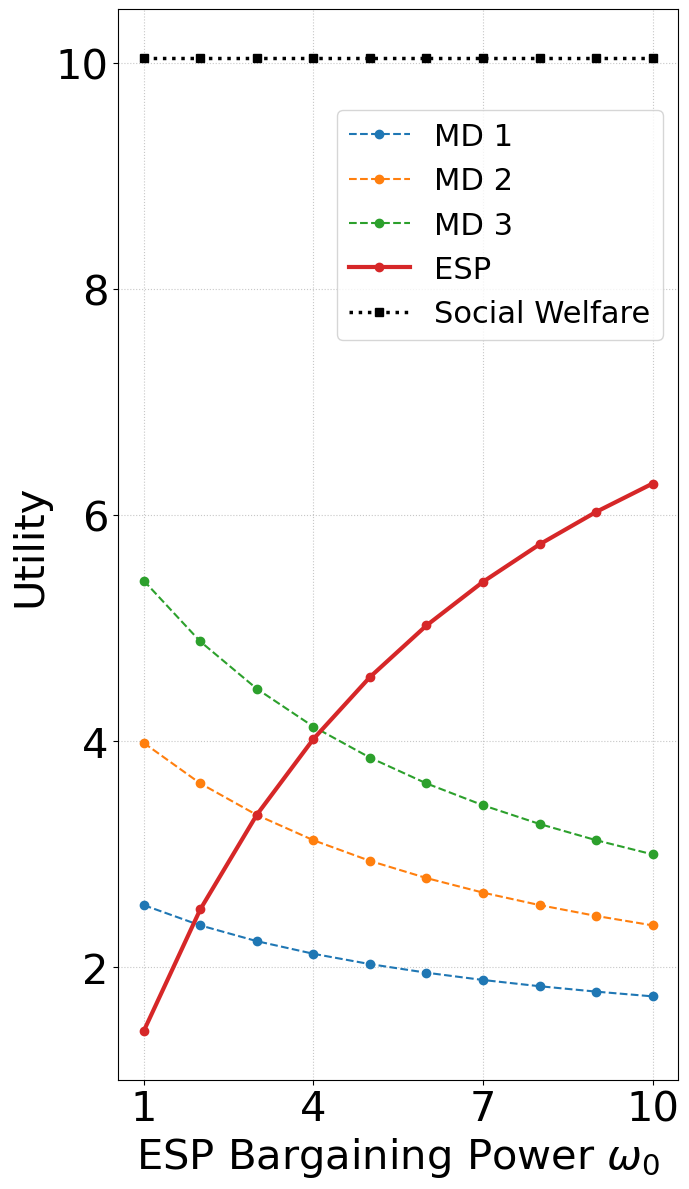

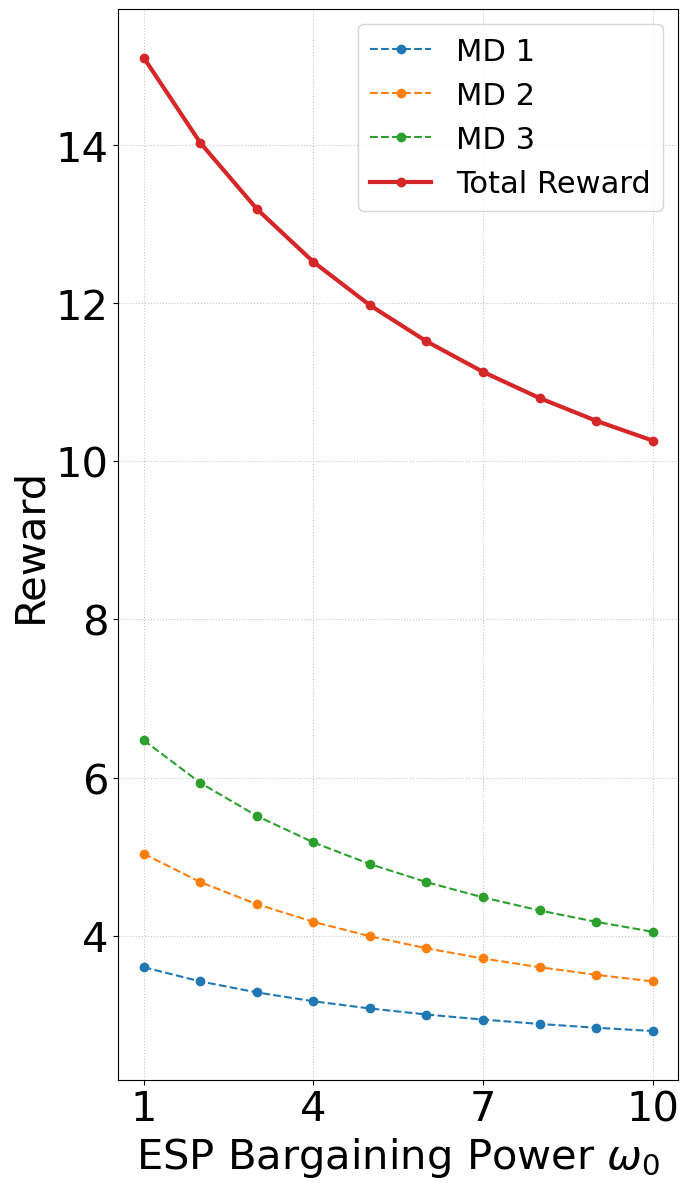

In [46]:
plt.rc('axes', labelsize=30)         # 坐标轴标签字体
plt.rc('xtick', labelsize=30)        # x 轴刻度
plt.rc('ytick', labelsize=30)        # y 轴刻度
plt.rc('legend', fontsize=22)        # 图例
plt.figure(figsize=(7, 12))

# 遍历每个参与者的utility历史数据并绘制
num_mds = len(MDs)
for i in range(num_mds + 1):
    if i < num_mds:
        # 这是 MD 的曲线
        plt.plot(omega_0_list, all_utilities[i], marker='o', linestyle='--',
                 label=f'MD {i+1}')
    else:
        # 这是 ESP 的曲线，我们用更粗、更醒目的线条来突出它
        plt.plot(omega_0_list, all_utilities[i], marker='o', linestyle='-',
                 linewidth=3, label='ESP')

plt.plot(omega_0_list, sw_history, 
         marker='s',              # 使用方形标记以作区分
         linestyle=':',             # 使用点线
         linewidth=2.5,
         color='black',           # 使用黑色
         label='Social Welfare')

# 美化图表
# plt.title('Utility & Social Welfare vs. ESP Bargaining Power ($\omega_0$)', fontsize=16)
plt.xlabel('ESP Bargaining Power $\omega_0$')
plt.ylabel('Utility') # Y轴标签改为更通用的 "Value"
plt.xticks([1, 4, 7, 10])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.92))
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 12))

# 遍历每个参与者的utility历史数据并绘制
num_mds = len(MDs)
for i in range(num_mds + 1):
    if i < num_mds:
        # 这是 MD 的曲线
        plt.plot(omega_0_list, all_rewards[i], marker='o', linestyle='--',
                 label=f'MD {i+1}')
    else:
        # 这是 ESP 的曲线，我们用更粗、更醒目的线条来突出它
        plt.plot(omega_0_list, all_rewards[i], marker='o', linestyle='-',
                 linewidth=3, label='Total Reward')

# 美化图表
# plt.title('Utility & Social Welfare vs. ESP Bargaining Power ($\omega_0$)', fontsize=16)
plt.xlabel('ESP Bargaining Power $\omega_0$')
plt.ylabel('Reward') # Y轴标签改为更通用的 "Value"
plt.xticks([1, 4, 7, 10])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [55]:
# Experiment 4: Impact of Task Workload
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "test.json")
config = Config(CONFIG_PATH)
config.params["lambda0"] = 10  # 固定任务到达率

def check_feasibility_for_workload(ESP, MDs):
    """
    Checks if a feasible solution likely exists for the given s, l, and MDs.
    This should be called BEFORE running the main ADMM optimizer.
    """
    lambda0, D0, s, l = ESP.lambda0, ESP.D0, ESP.s, ESP.l
    
    # 1. 筛选出“可用”的MDs (那些传输时间就没超时的)
    usable_MDs = []
    for md in MDs:
        # 检查约束一：传输时间 < 总延迟预算
        if s / md.Rn < D0:
            usable_MDs.append(md)
            
    if not usable_MDs:
        print(f"Feasibility Check Failed: No MDs can satisfy the transmission delay for s={s}.")
        return False

    # 2. 检查“可用”MDs的总算力是否足够
    total_max_power_ghz = sum(md.Fn for md in usable_MDs)
    required_power_ghz = (lambda0 * s * l) # 假设s单位是MB, l是cycle/bit -> 转换为GHz
                                                # 请根据您代码中的实际单位调整
    
    if total_max_power_ghz < required_power_ghz:
        print(f"Feasibility Check Failed: Total capacity of usable MDs ({total_max_power_ghz:.2f} GHz) "
              f"is less than required ({required_power_ghz:.2f} GHz) for s={s}, l={l}.")
        return False
        
    # 如果通过了以上两个关键检查，我们认为问题大概率是可解的
    return True

s_list = [0.1, 0.5, 1, 5, 10]
l_list = [0.8, 2.4, 4]
sw_history = [[] for _ in range(len(l_list))]
Dm_history = [[] for _ in range(len(l_list))]
pmean_history = [[] for _ in range(len(l_list))]
umean_history = [[] for _ in range(len(l_list))]
rmean_history = [[] for _ in range(len(l_list))]
for i,l in enumerate(l_list):
  for s in s_list:
    config.params["s"] = s
    config.params["l"] = l
    print(f"=====s: {s}, l:{l}=====")
    seed = 41
    MDs = create_MDs(config, seed=seed)
    esp = create_ESP(config, seed=seed)

    if not check_feasibility_for_workload(esp, MDs):
            print("----> Scenario is INFEASIBLE. Skipping ADMM run.")
    
    

    # lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
    # r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
    # lamb_admm, p_admm, Dmax_admm = NBS.ADMM(esp, MDs)
    # r_admm = NBS.negotiation(esp, MDs,lamb_admm, p_admm, Dmax_admm)
    # sw = model.social_welfare(esp, MDs, lamb_admm, p_admm)
    # print(f"ADMM Baseline: SW={sw}, Dmax={Dmax_admm}")
    # current_utility = [md.utility(p_admm[k], r_admm[k]) for k, md in enumerate(MDs)]
    # sw_history[i].append(sw)
    # Dm_history[i].append(Dmax_admm)
    # pmean_history[i].append(np.mean(p_admm))
    # umean_history[i].append(np.mean(current_utility))  # 不包括ESP的效用
    # rmean_history[i].append(np.mean(r_admm))  
    

=====s: 0.1, l:0.8=====
=====s: 0.5, l:0.8=====
=====s: 1, l:0.8=====
=====s: 5, l:0.8=====
=====s: 10, l:0.8=====
Feasibility Check Failed: Total capacity of usable MDs (11.49 GHz) is less than required (80.00 GHz) for s=10, l=0.8.
----> Scenario is INFEASIBLE. Skipping ADMM run.
=====s: 0.1, l:2.4=====
=====s: 0.5, l:2.4=====
=====s: 1, l:2.4=====
=====s: 5, l:2.4=====
Feasibility Check Failed: Total capacity of usable MDs (49.36 GHz) is less than required (120.00 GHz) for s=5, l=2.4.
----> Scenario is INFEASIBLE. Skipping ADMM run.
=====s: 10, l:2.4=====
Feasibility Check Failed: Total capacity of usable MDs (11.49 GHz) is less than required (240.00 GHz) for s=10, l=2.4.
----> Scenario is INFEASIBLE. Skipping ADMM run.
=====s: 0.1, l:4=====
=====s: 0.5, l:4=====
=====s: 1, l:4=====
=====s: 5, l:4=====
Feasibility Check Failed: Total capacity of usable MDs (49.36 GHz) is less than required (200.00 GHz) for s=5, l=4.
----> Scenario is INFEASIBLE. Skipping ADMM run.
=====s: 10, l:4====

In [ ]:
# --- 2. 绘图准备 ---
# 为了方便循环绘图，我们将所有数据和对应的标题、标签打包
all_data = {
    "Social Welfare": sw_history,
    "Maximum Average Delay ($D_{max}$)": Dm_history,
    "Mean Allocated Power ($\overline{p_n}$)": pmean_history,
    "Mean MD Utility ($\overline{U_n}$)": umean_history,
    "Mean Reward ($\overline{r_n}$)": rmean_history
}

# --- 3. 循环生成五张图表 ---
for title, data_history in all_data.items():
    
    # 为每个指标创建一张新图
    plt.figure(figsize=(10, 7))
    
    # 在同一张图上，为每个 l 值绘制一条曲线
    for i, l_val in enumerate(l_list):
        plt.plot(s_list, data_history[i], marker='o', linestyle='--', 
                 label=f'l = {l_val}')
    
    # 美化图表
    plt.title(f'{title} vs. Task Data Size ($s$)', fontsize=16)
    plt.xlabel('Task Data Size $s$ (MB)', fontsize=12) # 假设单位是MB
    plt.ylabel(title, fontsize=12)
    plt.xticks(s_list)
    
    # 使用对数坐标轴可能更适合s的变化范围
    # plt.xscale('log') 
    
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend(title='Computation Intensity ($l$)', fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
# Experiment 5: Impact of QoS Requirement